In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style ='darkgrid')
import matplotlib.pyplot as plt
% matplotlib inline
dir = '---'

In [2]:
data = pd.read_csv(dir + 'Causes_of_death.csv')
data.replace('.','')
pd.to_numeric(data['Population'],errors='coerce')
data.head()

,Year,Cause of Death,State,State FIPS Code,HHS Region,Age Range,Benchmark,Locality,Observed Deaths,Population,Expected Deaths,Potentially Excess Deaths
0,2005,Heart Disease,Vermont,VT,1,0-54,Floating,All,78.0,465112.0,77.0,1.0
1,2005,Heart Disease,Wyoming,WY,8,0-54,Floating,All,90.0,393845.0,62.0,28.0
2,2005,Heart Disease,North Dakota,ND,8,0-54,Floating,All,91.0,487085.0,73.0,18.0
3,2005,Heart Disease,Alaska,AK,10,0-54,Floating,All,111.0,557494.0,84.0,27.0
4,2005,Heart Disease,South Dakota,SD,8,0-54,Floating,All,117.0,587870.0,86.0,31.0


Get rid of data that is not helpful

Scale the death number by population size to compare state vs state

Unskew data (unused)

In [3]:
all_data = data[(data['Locality'] != 'All') & (data['Benchmark'] == 'Floating') 
               & (data['Potentially Excess Deaths'].notnull())
               & (data['State'] != '0')
               & (data['Age Range'] == '0-84')]
all_data = all_data.drop('Year', 1)
all_data = all_data.drop('State', 1)
all_data = all_data.drop('HHS Region', 1)
all_data = all_data.drop('Benchmark', 1)
all_data = all_data.drop('Age Range', 1)

all_data['Adj Excess Deaths'] = all_data['Potentially Excess Deaths'] / all_data['Population']
all_data['Adj Expected Deaths'] = all_data['Expected Deaths'] / all_data['Population']
all_data['Adj Observed Deaths'] = all_data['Observed Deaths'] / all_data['Population']

all_data['Potentially Excess Deaths_Scale']= np.log1p(all_data['Potentially Excess Deaths'])
all_data['Adj Excess Deaths_Scale']= np.log1p(all_data['Adj Excess Deaths'])

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5390 entries, 33660 to 199664
Data columns (total 12 columns):
Cause of Death                     5390 non-null object
State FIPS Code                    5390 non-null object
Locality                           5390 non-null object
Observed Deaths                    5390 non-null float64
Population                         5390 non-null float64
Expected Deaths                    5390 non-null float64
Potentially Excess Deaths          5390 non-null float64
Adj Excess Deaths                  5390 non-null float64
Adj Expected Deaths                5390 non-null float64
Adj Observed Deaths                5390 non-null float64
Potentially Excess Deaths_Scale    5390 non-null float64
Adj Excess Deaths_Scale            5390 non-null float64
dtypes: float64(9), object(3)
memory usage: 547.4+ KB


All states split by urban/rural broken down by Cause of Death

Notice rural tends to have higher adjusted death rates

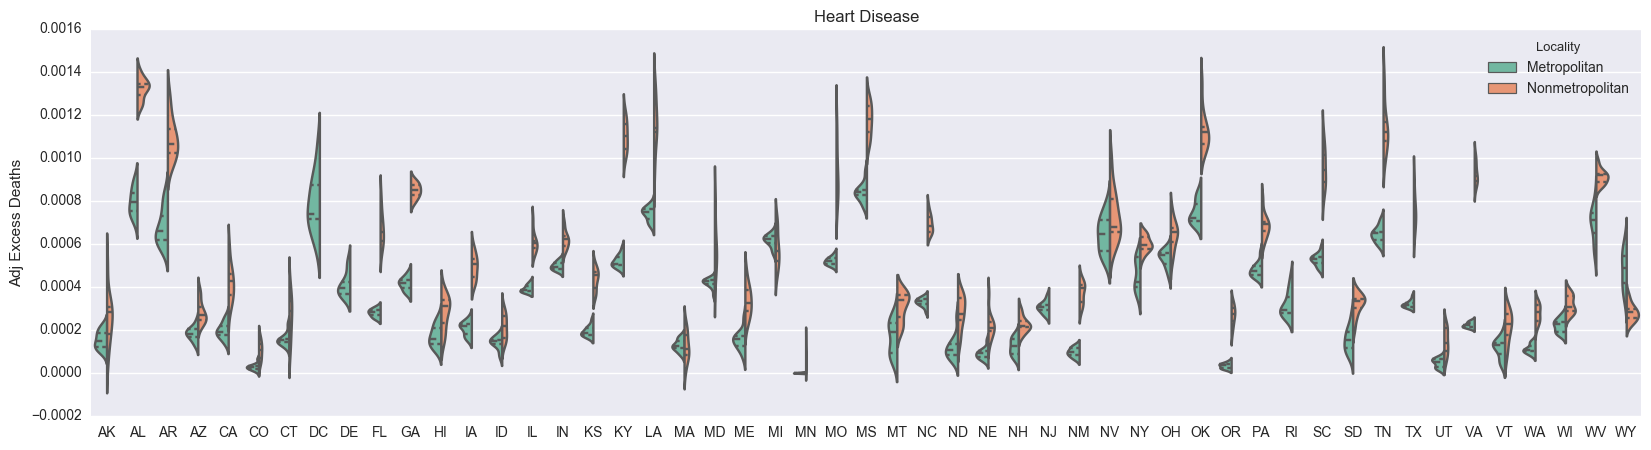

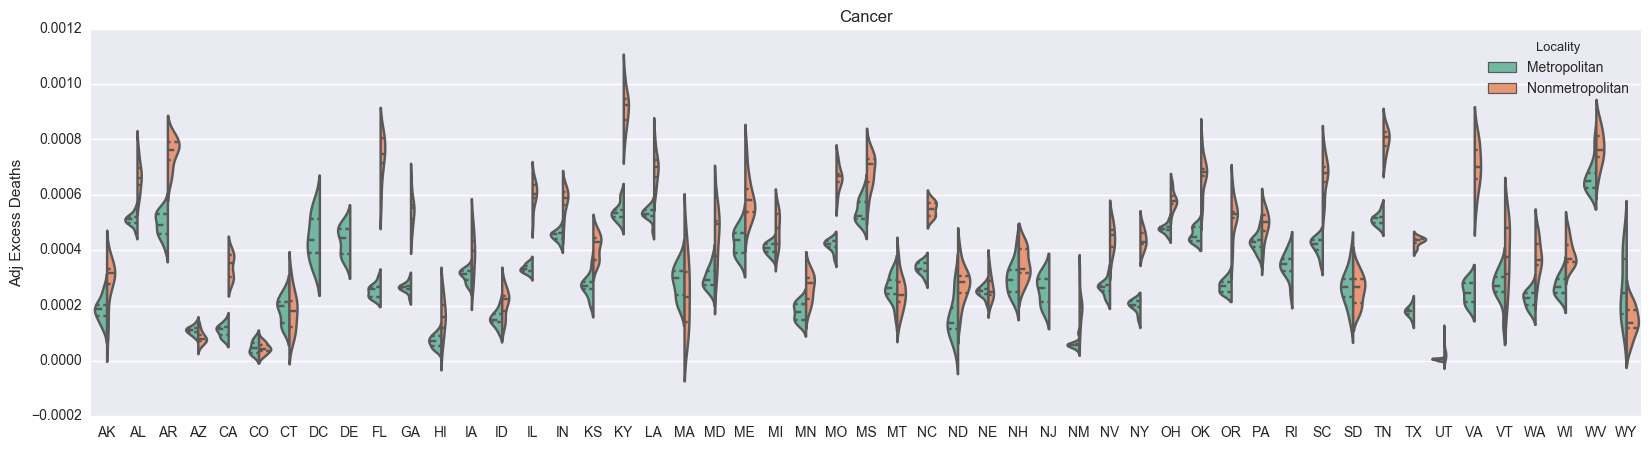

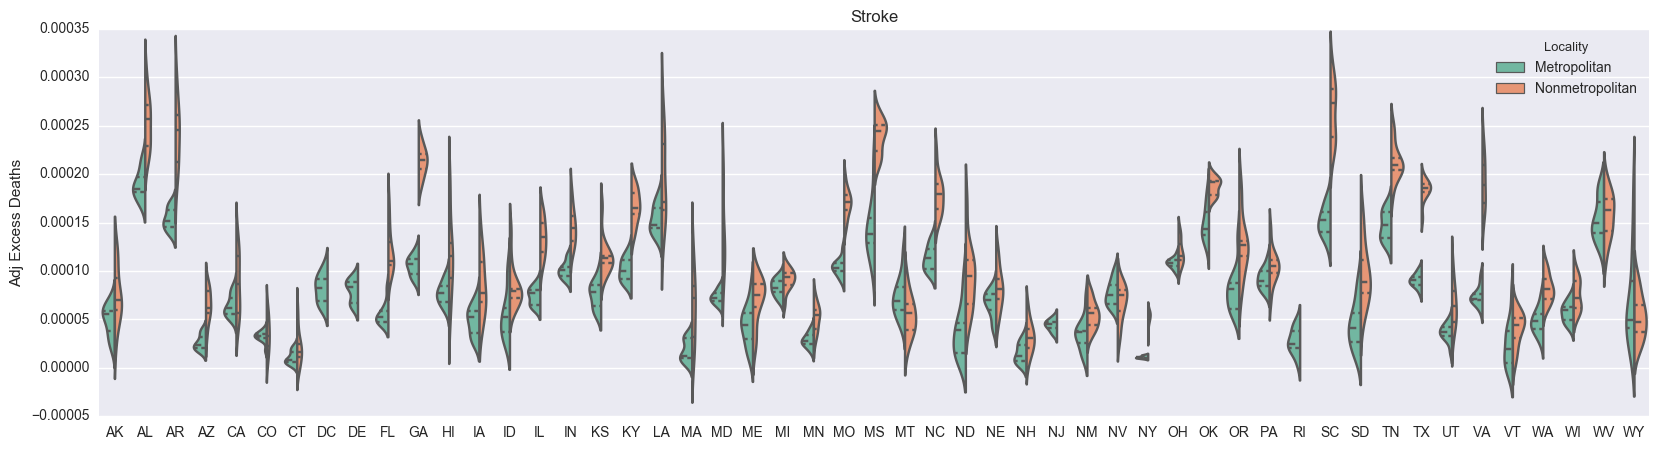

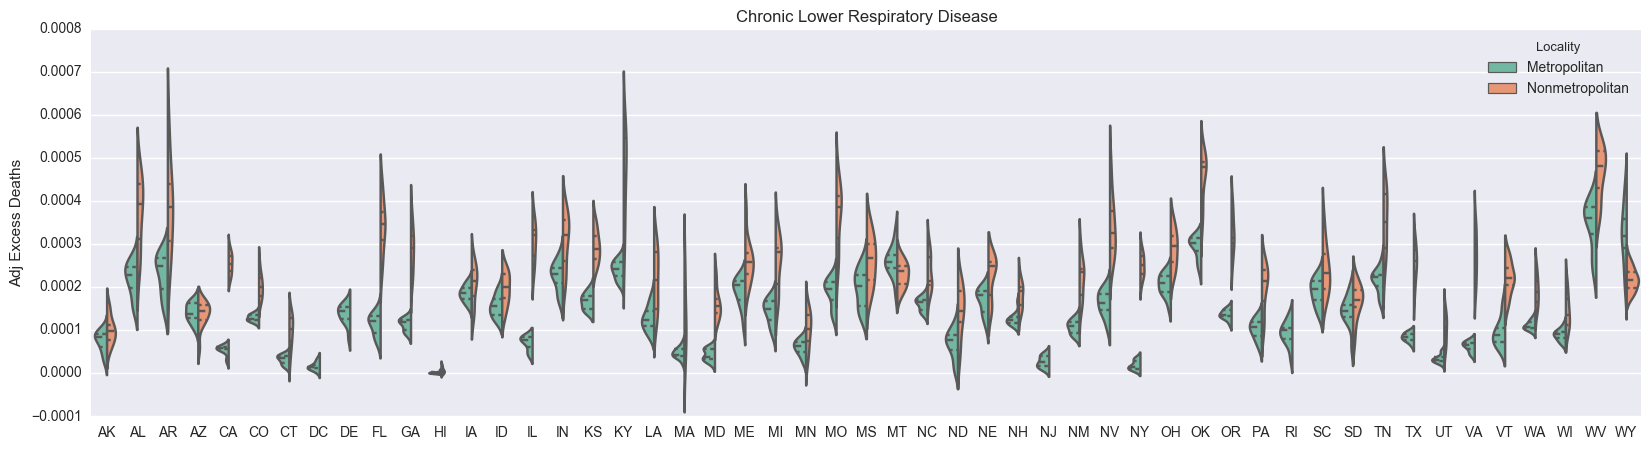

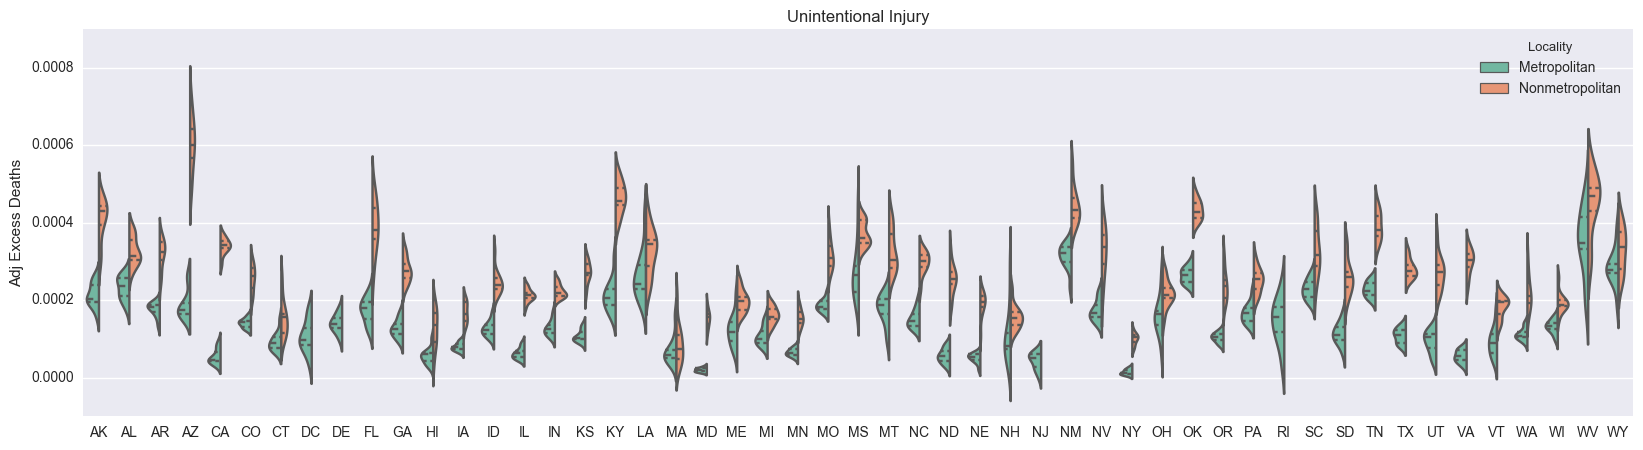

In [5]:
x = list(all_data['Cause of Death'].unique())
y = sorted(list(all_data['State FIPS Code'].unique()))

for i in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))
    sns.violinplot(ax =ax, y = 'Adj Excess Deaths' , x = 'State FIPS Code', palette = 'Set2', inner = 'quartile', 
               data = all_data[(all_data['Cause of Death'] == i)], hue = 'Locality', split = True, order = y)
    plt.title(i)
    plt.xlabel('')


This jointplot shows expected deaths by excess deaths.  Very large concentration in the bottom left corner (shown by the kde rings and the bar chart on the right edge).

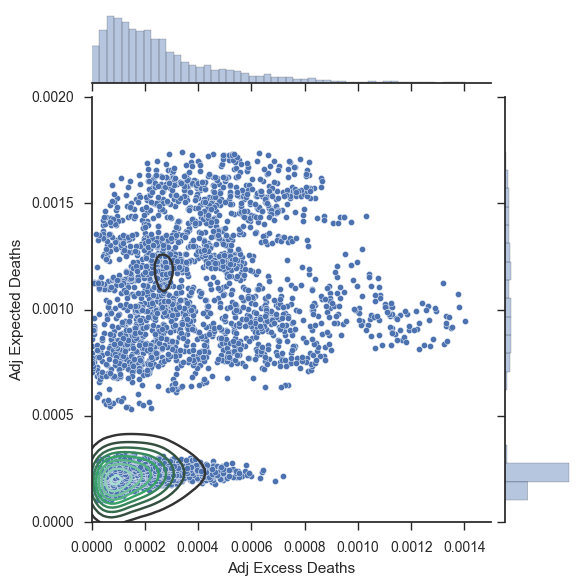

In [6]:
sns.set(style="ticks")
p = (sns.jointplot(all_data['Adj Excess Deaths'], all_data['Adj Expected Deaths'],
                  stat_func=None,edgecolor="w",xlim = (0,0.0015), ylim = (0,0.002))
     .plot_joint(sns.kdeplot, zorder = 1, n_levels = 10))

This new datafram only includes continuous values and Cause of Death to work with the PairGrid

In [7]:
num_data = all_data.ix[:,7:]
num_data['Cause of Death'] = all_data['Cause of Death']
num_data = num_data.drop('Potentially Excess Deaths_Scale', 1)
num_data = num_data.drop('Adj Excess Deaths_Scale', 1)
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5390 entries, 33660 to 199664
Data columns (total 4 columns):
Adj Excess Deaths      5390 non-null float64
Adj Expected Deaths    5390 non-null float64
Adj Observed Deaths    5390 non-null float64
Cause of Death         5390 non-null object
dtypes: float64(3), object(1)
memory usage: 210.5+ KB


This PairGrid shows adjusted excess, expected, and observed deaths broken down by the Cause of Death

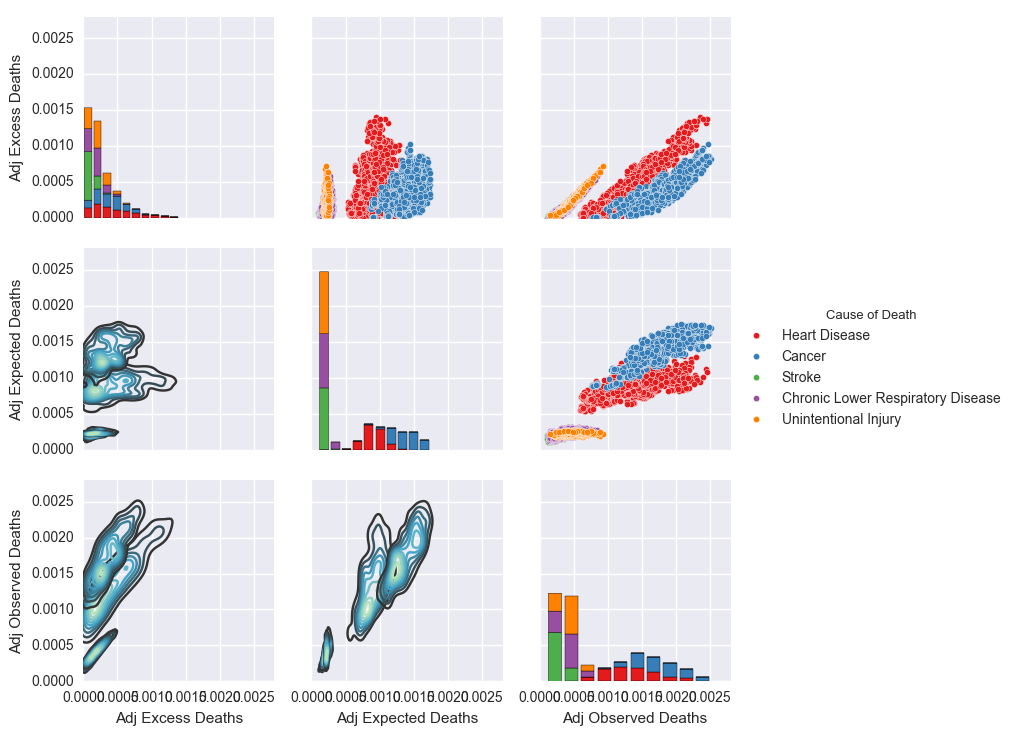

In [8]:
sns.set(style="darkgrid")

p = sns.PairGrid(num_data, hue = 'Cause of Death', palette = 'Set1',)
p.map_upper(plt.scatter, s = 20, edgecolor = 'w')
p.map_diag(plt.hist)
p.map_lower(sns.kdeplot, cmap = 'GnBu_d')
p.add_legend()

p.figsize = (30,30)

p.set(ylim = (0,0.0028))
p.set(xlim = (0,0.0028))